In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as pylab
params = {'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

SP = pd.read_csv('S&P_data.csv', parse_dates=[0])
SP = SP.loc[20:]
SP.reset_index(inplace=True)

## GARCH

n = SP.shape[0]
SP['Rtn'] = np.empty(n)

for i in range(1, n):
    SP.loc[i, 'Rtn'] = np.log(SP['spindx'][i] / SP['spindx'][i-1])
    
SP.loc[0, 'Rtn'] = np.mean(SP['Rtn'][1:])

SP['(Rtn-Rbar)^2'] = np.empty(n)

for i in range(0, n):
    SP.loc[i, '(Rtn-Rbar)^2'] = (SP['Rtn'][i] - SP['Rtn'][0]) ** 2
    
# Conditions From Optimizer
    
omega = 1.191562e-06
alpha = 0.08305225
beta = 0.9094939
alpha_beta = alpha + beta
LT_vol = np.sqrt(252*(omega)/(1-alpha_beta))

SP['Cond Var'] = np.empty(n)
SP.loc[0, 'Cond Var'] = SP['Rtn'][0] ** 2

for i in range(1, n):
    SP.loc[i, 'Cond Var'] = omega + alpha * SP['(Rtn-Rbar)^2'][i-1] + beta * SP['Cond Var'][i-1]
    
SP['Log L'] = np.empty(n)
SP.loc[0, 'Log L'] = '--'

for i in range(1, n):
    SP.loc[i, 'Log L'] = -(np.log(np.sqrt(SP['Cond Var'][i])))-0.5*(SP['(Rtn-Rbar)^2'][i]/SP['Cond Var'][i])
    
SP['GARCH vol'] = np.empty(n)
SP.loc[0, 'GARCH vol'] = '--'

for i in range(1, n):
    SP.loc[i, 'GARCH vol'] = np.sqrt(SP['Cond Var'][i] * 252)
    
LogL = np.sum(SP['Log L'][1:])
LogL

# Returns

Returns = pd.read_csv('S&P_data.csv', parse_dates=[0])
Returns = Returns.loc[20:]
Returns.reset_index(inplace=True)

Returns['GARCH Rtn'] = np.empty(n)
Returns.loc[0, 'GARCH Rtn'] = SP['Rtn'][0]

for i in range(1, n):
    Returns.loc[i, 'GARCH Rtn'] = SP['Rtn'][i] * (SP['GARCH vol'][n-1] / SP['GARCH vol'][i])

## Historical VaR Estimates

Quantiles = [0.10, 1, 5, 10]
VaR = pd.DataFrame({'Quantile': ['0.10%', '1%', '5%', '10%'], 'Unadjusted': [0.0, 0.0, 0.0, 0.0], 'GARCH Adjusted': [0.0, 0.0, 0.0, 0.0]})

for i in range(0, 4):
    VaR.loc[i, 'Unadjusted'] = -np.percentile(SP['Rtn'], Quantiles[i])
    
for i in range(0, 4):
    VaR.loc[i, 'GARCH Adjusted'] = -np.percentile(Returns['GARCH Rtn'], Quantiles[i])
    
VaR_print = pd.DataFrame({'Quantile': ['0.10%', '1%', '5%', '10%'], 'Unadjusted': [0.0, 0.0, 0.0, 0.0], 'GARCH Adjusted': [0.0, 0.0, 0.0, 0.0]})

for i in range(0, 4):
    VaR_print.loc[i, 'Unadjusted'] = '{:.2%}'.format(-np.percentile(SP['Rtn'], Quantiles[i]))
    
for i in range(0, 4):
    VaR_print.loc[i, 'GARCH Adjusted'] = '{:.2%}'.format(-np.percentile(Returns['GARCH Rtn'], Quantiles[i]))
    
VaR_print

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

n = SP.shape[0]

GARCH_standardized = np.empty(n-1)

for i in range(0, n-1):
    GARCH_standardized[i] = SP['Rtn'][i+1] / np.sqrt(SP['Cond Var'][i+1])

# Set Initial Standard Deviation

current_std = LT_vol/np.sqrt(252)

Starting_values = pd.DataFrame({'sigma0': [current_std], 'r0': [SP['Rtn'][n-1]]})
Starting_values['sigma1'] = np.sqrt(omega + alpha * (Starting_values['r0'][0]) ** 2 + beta * Starting_values['sigma0'][0] ** 2)

In [7]:
## I.I.D. Bootstrap

# Day 1

nreps = 10000

Row_1 = np.empty(nreps)
columns_1 = ['r1', 'sigma1']

for i in range(0, nreps):
    Row_1[i] = np.random.randint(2, n-1)
    
set_1 = pd.DataFrame(index=Row_1, columns=columns_1)
set_1.reset_index(inplace=True)
set_1 = set_1.rename(columns={'index': 'Row no.'})

for i in range(0, nreps):
    a = int(Row_1[i])
    set_1.loc[i, 'r1'] = Starting_values['sigma1'][0] * GARCH_standardized[a]
    
for i in range(0, nreps):
    set_1.loc[i, 'sigma1'] = np.sqrt(omega + alpha * (set_1['r1'][i]) ** 2 + beta * Starting_values['sigma1'][0] ** 2)
    
# Day 2

Row_2 = np.empty(nreps)
columns_2 = ['r2', 'sigma2']

for i in range(0, nreps):
    Row_2[i] = np.random.randint(2, n-1)
    
set_2 = pd.DataFrame(index=Row_2, columns=columns_2)
set_2.reset_index(inplace=True)
set_2 = set_2.rename(columns={'index': 'Row no.'})

for i in range(0, nreps):
    a = int(Row_2[i])
    set_2.loc[i, 'r2'] = set_1['sigma1'][i] * GARCH_standardized[a]
    
for i in range(0, nreps):
    set_2.loc[i, 'sigma2'] = np.sqrt(omega + alpha * (set_2['r2'][i]) ** 2 + beta * set_1['sigma1'][i] ** 2)
    
# Day 3

Row_3 = np.empty(nreps)
columns_3 = ['r3', 'sigma3']

for i in range(0, nreps):
    Row_3[i] = np.random.randint(2, n-1)
    
set_3 = pd.DataFrame(index=Row_3, columns=columns_3)
set_3.reset_index(inplace=True)
set_3 = set_3.rename(columns={'index': 'Row no.'})

for i in range(0, nreps):
    a = int(Row_3[i])
    set_3.loc[i, 'r3'] = set_2['sigma2'][i] * GARCH_standardized[a]
    
for i in range(0, nreps):
    set_3.loc[i, 'sigma3'] = np.sqrt(omega + alpha * (set_3['r3'][i]) ** 2 + beta * set_2['sigma2'][i] ** 2)
    
# Day 4

Row_4 = np.empty(nreps)
columns_4 = ['r4', 'sigma4']

for i in range(0, nreps):
    Row_4[i] = np.random.randint(2, n-1)
    
set_4 = pd.DataFrame(index=Row_4, columns=columns_4)
set_4.reset_index(inplace=True)
set_4 = set_4.rename(columns={'index': 'Row no.'})

for i in range(0, nreps):
    a = int(Row_4[i])
    set_4.loc[i, 'r4'] = set_3['sigma3'][i] * GARCH_standardized[a]
    
for i in range(0, nreps):
    set_4.loc[i, 'sigma4'] = np.sqrt(omega + alpha * (set_4['r4'][i]) ** 2 + beta * set_3['sigma3'][i] ** 2)
    
# Day 5

Row_5 = np.empty(nreps)
columns_5 = ['r5', 'sigma5']

for i in range(0, nreps):
    Row_5[i] = np.random.randint(2, n-1)
    
set_5 = pd.DataFrame(index=Row_5, columns=columns_5)
set_5.reset_index(inplace=True)
set_5 = set_5.rename(columns={'index': 'Row no.'})

for i in range(0, nreps):
    a = int(Row_4[i])
    set_5.loc[i, 'r5'] = set_4['sigma4'][i] * GARCH_standardized[a]
    
for i in range(0, nreps):
    set_5.loc[i, 'sigma5'] = np.sqrt(omega + alpha * (set_5['r5'][i]) ** 2 + beta * set_4['sigma4'][i] ** 2)
    
# Day 6

Row_6 = np.empty(nreps)
columns_6 = ['r6', 'sigma6']

for i in range(0, nreps):
    Row_6[i] = np.random.randint(2, n-1)
    
set_6 = pd.DataFrame(index=Row_6, columns=columns_6)
set_6.reset_index(inplace=True)
set_6 = set_6.rename(columns={'index': 'Row no.'})

for i in range(0, nreps):
    a = int(Row_6[i])
    set_6.loc[i, 'r6'] = set_5['sigma5'][i] * GARCH_standardized[a]
    
for i in range(0, nreps):
    set_6.loc[i, 'sigma6'] = np.sqrt(omega + alpha * (set_6['r6'][i]) ** 2 + beta * set_5['sigma5'][i] ** 2)
    
# Day 7

Row_7 = np.empty(nreps)
columns_7 = ['r7', 'sigma7']

for i in range(0, nreps):
    Row_7[i] = np.random.randint(2, n-1)
    
set_7 = pd.DataFrame(index=Row_7, columns=columns_7)
set_7.reset_index(inplace=True)
set_7 = set_7.rename(columns={'index': 'Row no.'})

for i in range(0, nreps):
    a = int(Row_7[i])
    set_7.loc[i, 'r7'] = set_6['sigma6'][i] * GARCH_standardized[a]
    
for i in range(0, nreps):
    set_7.loc[i, 'sigma7'] = np.sqrt(omega + alpha * (set_7['r7'][i]) ** 2 + beta * set_6['sigma6'][i] ** 2)
    
# Day 8

Row_8 = np.empty(nreps)
columns_8 = ['r8', 'sigma8']

for i in range(0, nreps):
    Row_8[i] = np.random.randint(2, n-1)
    
set_8 = pd.DataFrame(index=Row_8, columns=columns_8)
set_8.reset_index(inplace=True)
set_8 = set_8.rename(columns={'index': 'Row no.'})

for i in range(0, nreps):
    a = int(Row_8[i])
    set_8.loc[i, 'r8'] = set_7['sigma7'][i] * GARCH_standardized[a]
    
for i in range(0, nreps):
    set_8.loc[i, 'sigma8'] = np.sqrt(omega + alpha * (set_8['r8'][i]) ** 2 + beta * set_7['sigma7'][i] ** 2)
    
# Day 9

Row_9 = np.empty(nreps)
columns_9 = ['r9', 'sigma9']

for i in range(0, nreps):
    Row_9[i] = np.random.randint(2, n-1)
    
set_9 = pd.DataFrame(index=Row_9, columns=columns_9)
set_9.reset_index(inplace=True)
set_9 = set_9.rename(columns={'index': 'Row no.'})

for i in range(0, nreps):
    a = int(Row_9[i])
    set_9.loc[i, 'r9'] = set_8['sigma8'][i] * GARCH_standardized[a]
    
for i in range(0, nreps):
    set_9.loc[i, 'sigma9'] = np.sqrt(omega + alpha * (set_9['r9'][i]) ** 2 + beta * set_8['sigma8'][i] ** 2)
    
# Day 10

Row_10 = np.empty(nreps)
columns_10 = ['r10', '10-day Simulated Rtn']

for i in range(0, nreps):
    Row_10[i] = np.random.randint(2, n-1)
    
set_10 = pd.DataFrame(index=Row_10, columns=columns_10)
set_10.reset_index(inplace=True)
set_10 = set_10.rename(columns={'index': 'Row no.'})

for i in range(0, nreps):
    a = int(Row_10[i])
    set_10.loc[i, 'r10'] = set_9['sigma9'][i] * GARCH_standardized[a]
    
# Add returns to find 10-day VaR
    
for i in range(0, nreps):
    set_10.loc[i, '10-day Simulated Rtn'] = set_1['r1'][i] + set_2['r2'][i] + set_3['r3'][i] + set_4['r4'][i] + set_5['r5'][i] + set_6['r6'][i] + set_7['r7'][i] + set_8['r8'][i] + set_9['r9'][i] + set_10['r10'][i]

In [8]:
## Compare Historical VaR with FHS
Quantiles = [0.10, 1, 5, 10]
Historical_VaR = pd.DataFrame({'Quantile': ['0.10%', '1%', '5%', '10%'], 'Scaled Up Daily VaR': [0.0, 0.0, 0.0, 0.0], 'FHS': [0.0, 0.0, 0.0, 0.0]})

for i in range(0, 4):
    Historical_VaR.loc[i, 'Scaled Up Daily VaR'] = VaR['GARCH Adjusted'][i] * np.sqrt(10)
    
for i in range(0, 4):
    Historical_VaR.loc[i, 'FHS'] = -np.percentile(set_10['10-day Simulated Rtn'], Quantiles[i])
    
Historical_VaR_print = pd.DataFrame({'Quantile': ['0.10%', '1%', '5%', '10%'], 'Scaled Up Daily VaR': [0.0, 0.0, 0.0, 0.0], 'FHS': [0.0, 0.0, 0.0, 0.0]})

for i in range(0, 4):
    Historical_VaR_print.loc[i, 'Scaled Up Daily VaR'] = '{:.2%}'.format(VaR['GARCH Adjusted'][i] * np.sqrt(10))
    
for i in range(0, 4):
    Historical_VaR_print.loc[i, 'FHS'] = '{:.2%}'.format(-np.percentile(set_10['10-day Simulated Rtn'], Quantiles[i]))

Historical_VaR_print

,Quantile,Scaled Up Daily VaR,FHS
0,0.10%,23.61%,19.90%
1,1%,13.24%,10.96%
2,5%,8.52%,6.68%
3,10%,6.66%,4.72%


In [9]:
Comparison = pd.DataFrame({'Quantile': ['0.10%', '1%', '5%', '10%'], 'Unadjusted': [0.0, 0.0, 0.0, 0.0], 'FHS': [0.0, 0.0, 0.0, 0.0]})

for i in range(0, 4):
    Comparison.loc[i, 'Unadjusted'] = VaR['Unadjusted'][i]
    
for i in range(0, 4):
    Comparison.loc[i, 'FHS'] = -np.percentile(set_10['10-day Simulated Rtn'], Quantiles[i])
    
Comparison_print = pd.DataFrame({'Quantile': ['0.10%', '1%', '5%', '10%'], 'Unadjusted': [0.0, 0.0, 0.0, 0.0], 'FHS': [0.0, 0.0, 0.0, 0.0]})

for i in range(0, 4):
    Comparison_print.loc[i, 'Unadjusted'] = '{:.2%}'.format(VaR['Unadjusted'][i])
    
for i in range(0, 4):
    Comparison_print.loc[i, 'FHS'] = '{:.2%}'.format(-np.percentile(set_10['10-day Simulated Rtn'], Quantiles[i]))
    
Comparison_print

,Quantile,Unadjusted,FHS
0,0.10%,4.84%,19.90%
1,1%,2.83%,10.96%
2,5%,1.78%,6.68%
3,10%,1.27%,4.72%


In [15]:
VaR_print = pd.DataFrame({'Quantile': ['0.10%', '1%', '5%', '10%'], 'Unadjusted': [0.0, 0.0, 0.0, 0.0], 'FHS': [0.0, 0.0, 0.0, 0.0], 'GARCH Adjusted': [0.0, 0.0, 0.0, 0.0]})

for i in range(0, 4):
    VaR_print.loc[i, 'Unadjusted'] = '{:.2%}'.format(-np.percentile(SP['Rtn'], Quantiles[i]))
    
for i in range(0, 4):
    VaR_print.loc[i, 'GARCH Adjusted'] = '{:.2%}'.format(VaR['GARCH Adjusted'][i] * np.sqrt(10))
    
for i in range(0, 4):
    VaR_print.loc[i, 'FHS'] = '{:.2%}'.format(-np.percentile(set_10['10-day Simulated Rtn'], Quantiles[i]))
    
VaR_print

,Quantile,Unadjusted,FHS,GARCH Adjusted
0,0.10%,4.84%,19.90%,23.61%
1,1%,2.83%,10.96%,13.24%
2,5%,1.78%,6.68%,8.52%
3,10%,1.27%,4.72%,6.66%


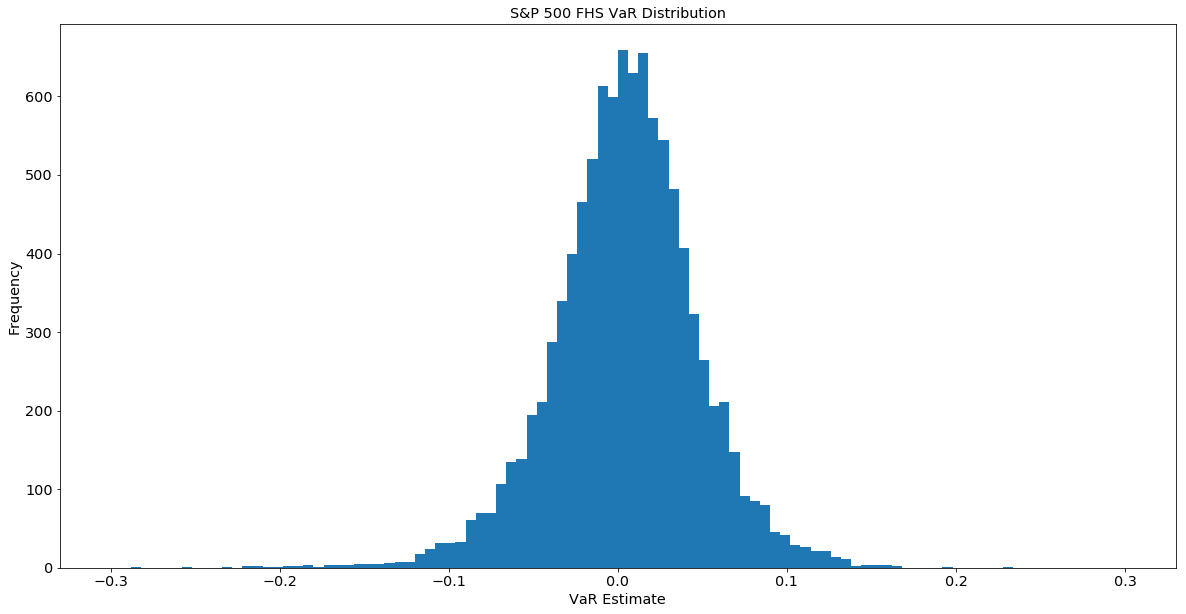

In [16]:
## Predictive Density

results = np.empty(nreps)

for i in range(nreps):
    results[i] = set_10['10-day Simulated Rtn'][i]
    
plt.hist(results, bins=100, range=(-.3, .3))
plt.title('S&P 500 FHS VaR Distribution')
plt.xlabel('VaR Estimate')
plt.ylabel('Frequency')
plt.savefig('SP_distribution.png');